<a href="https://colab.research.google.com/github/rafa-moni/rafa-moni.github.io/blob/main/CMSC320_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection



There has been tons of analysis on music data, especially revolving around songs in the Billbord Top 100. However, how does this analysis change when we focus our insights onto videogame music? How have trends shaped and changed in the videogame music industry? Does the genre or length of a song potentially affect a songs? In this project, we aim to conduct a generalized analysis on video game music and find answers to these questions. Based on our findings, we will also predict an average Top 50 playlist based on listening habits of videogame music enjoyers. 

To aquire this data, we looked to the Materia Collective, a record label that puts out exclusively videogame soundtracks and covers of videogame soundtrakcs. Their bandcamp site (https://bandcamp.materiacollective.com/) contains a table with links to bancdcamp pages for all of the albums the label has published.With some html scraping we can extract some information about the albums.

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import numpy as np
from pandas.core.arrays.datetimelike import TimelikeOps

In [ ]:
# Setting up accumulator dataframes
master_track_df = pd.DataFrame()
master_album_df = pd.DataFrame()

In [ ]:
# Get a list of links to all the album bandcamp sites
html = requests.get('https://bandcamp.materiacollective.com/')
data = BeautifulSoup(html.text, 'html.parser')

urls = []

tiles1 = data.findAll('li', {'class': 'featured-item'})
tiles2 = data.findAll('li', {'class': 'music-grid-item square first-four '})
tiles3 = data.findAll('li', {'class': 'music-grid-item square '})

for square in tiles1 + tiles2 + tiles3:
    square = str(square)
    square = square[square.index('href="') + 6:]
    square = square[:square.index('"')]
    if square.index('/album/') == 0:
        square = 'https://bandcamp.materiacollective.com' + square
    urls.append(square)
urls

['https://ericbuchholz.bandcamp.com/album/a-merry-hyrule-christmas?label=3683409508&amp;tab=music',
 'https://familyjules7x.bandcamp.com/album/jack-of-hearts?label=3683409508&amp;tab=music',
 'https://familyjules7x.bandcamp.com/album/king-of-hearts?label=3683409508&amp;tab=music',
 'https://familyjules7x.bandcamp.com/album/queen-of-hearts?label=3683409508&amp;tab=music',
 'https://valterabreu.bandcamp.com/album/nightslink-original-game-soundtrack?label=3683409508&amp;tab=music',
 'https://ryanike.bandcamp.com/album/shadows-over-loathing-original-game-soundtrack?label=3683409508&amp;tab=music',
 'https://waynestrange.bandcamp.com/album/pursuit-a-great-turnabout-from-the-great-ace-attorney?label=3683409508&amp;tab=music',
 'https://videogamemusicbox.bandcamp.com/album/music-box-classics-kingdom-hearts-ii?label=3683409508&amp;tab=music',
 'https://videogamemusicbox.bandcamp.com/album/music-box-classics-mega-man-2?label=3683409508&amp;tab=music',
 'https://videogamemusicbox.bandcamp.com/al

That's a lot of albums! Each website has about the same format. There are some weird quirks about some pages, like full rows in the song list for lyrics, and links to music videos, but we can account for those cases.

In [ ]:
for url in urls:
    html = requests.get(url)
    data = BeautifulSoup(html.text, 'html.parser')

    # Getting album title and artist
    album_title = data.find('h2', {'class': 'trackTitle'})
    artist = str(album_title.next_sibling.next_sibling.find('a'))
    artist = artist[artist.index('>') + 1:-4]
    album_title = str(album_title)[36:-27]

    # Getting prices for each of the formats
    formats = ['Digital Album', 'Compact Disc', 'Record/Vinyl']
    prices = [np.nan] * len(formats)
    for i in range(0,len(formats)):
        price = data.find(text=re.compile('Buy ' + formats[i]))
        # If an element with the right format is found, extract the price and add to array
        # In the case of None, there is no option to buy this way, only either CD or Vinyl
        if price != None:
            prices[i] = str(price.next_element.next_element.find(text=re.compile('\$')))[1:]

    # Getting a list of all of the tags for the album
    tags = []
    for tag_data in data.findAll('a', {'class': 'tag'}):
        tag_data = str(tag_data)
        tags.append(tag_data[tag_data.index('>') + 1:-4])

    # Get the album release date
    from itertools import islice
    release = str(next(islice(data.find('div',{'class': 'tralbumData tralbum-credits'}).children, 0, None)))
    release = pd.to_datetime(release[39:-26])

    # Clean the HTML table, because some include lyrics rows
    tracks_table = data.find('table', {'class': 'track_list track_table'})
    table_clean = '<table class="track_list track_table" id="track_table">\n'
    tracks_table = data.find('table', {'class': 'track_list track_table'})
    for row in tracks_table.findAll('tr', {'class': 'track_row_view linked'}):
        table_clean = table_clean + str(row)
    table_clean = table_clean + '</table>'
    track_df = pd.read_html(table_clean)[0]
    
    # Clean the resulting pandas dataframe
    track_df.rename(columns={1: "Number in Album", 2: "Title"}, inplace=True)
    track_df.drop(columns=[0,3,4], axis=1, inplace=True)
    track_df["Number in Album"] = track_df["Number in Album"].astype(float).astype(int)
    track_df["Title"] = track_df["Title"].apply(lambda x: x.rstrip('abcdefghijklmnopqrstuvwxyz '))
    track_df["Duration"] = track_df["Title"].apply(lambda x: x[-5:])
    track_df["Duration"] = pd.to_timedelta('00:' + track_df["Duration"])
    track_df["Title"] = track_df["Title"].apply(lambda x: x[:-7])
    track_df['Album Title'] = album_title

    # Get cummulative values from this section of the track dataframe
    album_duration = track_df['Duration'].sum()
    number_of_tracks = track_df['Number in Album'].max()

    # Construct the new row for the album dataframe
    album_data = [[album_title, artist, release, number_of_tracks, album_duration, prices[0], prices[1], prices[2], tags]]
    album_cols = ['Album Title', 'Artist', 'Release Date', 'Number of Tracks', 'Album Duration', 'Digital Price', 'CD Price', 'Vinyl Price', 'Tags']
    album_df = pd.DataFrame(album_data, columns=album_cols)

    # Concatenate to accumulators
    master_track_df = pd.concat([master_track_df, track_df])
    master_album_df = pd.concat([master_album_df, album_df])

In [ ]:
master_album_df['Digital Price'] = master_album_df['Digital Price'].apply(lambda x: np.nan if x == 'one' else x)
#master_track_df.to_csv('bandcamp_track_df.csv',index=False)  Commented out so we don't accidentally overwrite the data we originally scraped.
#master_album_df.to_csv('bandcamp_album_df.csv',index=False)

So now we have data from bandcamp on the Materia Collective. Thing is, it's not the greatest. The artists have no clear rule for how they are listed. Most of the time, there is one artist and it's listed in the artist place on the webpage only. Unfortunately, many times there are many artists. For some albums, this means the album artist is 'Various Artists' and each track title is formatted [Artist] - [Track Title] (which is awfule because some normal track titles already have a hyphen). For other albums, the artist for the album is listed as 'artist1, artist2' or 'artist1 and artist2' or 'artist1&artist2'. It's a bit of a nightmare. Finally, the most interesting feature of this particular set of data isn't in this set of data: popularity.

So... now that we've put this much work into scraping Bandcamp, let's use the Spotify API.

In [ ]:
# Spotify stuff
!pip install Spotipy
import os
os.environ['SPOTIPY_CLIENT_ID'] = '[MY CLIENT ID]'
os.environ['SPOTIPY_CLIENT_SECRET'] = '[MY CLIENT SECRET]'
import spotipy

In [ ]:
from spotipy.oauth2 import SpotifyClientCredentials
spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials())

In [ ]:
# Load our data back in and do some additional cleaning--some unprintable characters
track_df = pd.read_csv('bandcamp_track_df.csv')
track_df['Title'] = track_df['Title'].apply(lambda x: x[x.index(' - ') + 3:] if ' - ' in x else x)
track_df['Title'] = track_df['Title'].apply(lambda x: x.replace('\u200b',''))
track_df['Album Title'] = track_df['Album Title'].apply(lambda x: x.replace('\u200b',''))
album_df = pd.read_csv('bandcamp_album_df.csv')
album_df['Album Title'] = album_df['Album Title'].apply(lambda x: x.replace('\u200b',''))

Okay, so the plan is to sort the albums into two groups: those that the Spotify search algorithm will likely easily find just from the album title, and those that it will probably also need a song title to find. We make this distinction by the number of spaces that appear in the album title, which we make a new dummy column in the album dataframe.

Part 1 - albums with short titles:

In [ ]:
# Make list of tuples (Album Title, query that we'll give to Spotify)
album_df['spaces'] = album_df['Album Title'].apply(lambda x: x.count(' '))
lessthan3 = album_df[album_df['spaces'] < 3]
searches = lessthan3['Album Title'].apply(lambda album_title: (album_title, track_df[track_df['Album Title'] == album_title]['Title'].iloc[0] + ' ' + album_title))
searches

16     (Live in Japan, The World Warrior (from "Stree...
29     (Live in Brazil, Prelude (from "Final Fantasy"...
32     (Gris Piano Collections, Gris, Pt. 1 Gris Pian...
35     (Noises from Shibuya, Make or Break (Shatter t...
42     (Unplugged, Bros on the Road (from "FINAL FANT...
45     (Undertale LIVE, Once Upon a Time Undertale LIVE)
48     (Crest of Flames, Three Houses Main Theme Cres...
55           (Fallen Hero, Once Upon a Time Fallen Hero)
61     (Towards the Sun, My Burden is Light Towards t...
67          (Fuzzy Pickles, Bein' Friends Fuzzy Pickles)
74          (The Keyblade War, Destati The Keyblade War)
75     (Strings of Fate, Last Surprise (Instrumental ...
78                         (Reignite, Reignite Reignite)
84     (Metroid Piano, Prologue (from "Super Metroid"...
85     (Bits and Bytes, Main Theme (Chrono Trigger) B...
87     (Multiplayer 5: Connection, Snake Eater Multip...
93     (Time &amp; Space, Arceus and the Creation Tim...
94           (Parallelus, Dream

In [ ]:
song_query_results = []
for i, (album_title, search_q) in searches.iteritems():
    #result = spotify.search(q=search_q, type='track') Commented out so we don't accidentally query Spotify more
    song_query_results.append((i,result))

In [ ]:
spotify_albums_df_pt1 = pd.DataFrame()
j = 0
for (i, result) in song_query_results:
    album_info = result['tracks']['items'][0]['album']
    album_name = album_info['name']
    album_id = album_info['id']
    album_release = album_info['release_date']
    album_no_tracks = album_info['total_tracks']
    album_type = album_info['album_type']
    album_cover_url = album_info['images'][0]['url']
    artists = []
    for artist in album_info['artists']:
        artists.append(artist['name'])
    row = [[i, album_id, album_name, artists, album_type, album_no_tracks, album_release, album_cover_url, 'track', j]]
    j = j + 1
    #print(row)
    labels = ['Index', 'Album ID', 'Album Title', 'Artists', 'Album Type', 'Number of Tracks', 'Spotify Release Date', 'Image URL', 'Search Type', 'Search Index']
    df_row = pd.DataFrame(row, columns=labels)

    spotify_albums_df_pt1 = pd.concat([spotify_albums_df_pt1, df_row])
spotify_albums_df_pt1

,Index,Album ID,Album Title,Artists,Album Type,Number of Tracks,Spotify Release Date,Image URL,Search Type,Search Index
0,16,4Wmo27x9XdijBgMwWmzSx6,Live in Japan,[Video Game Orchestra],album,13,2022-05-20,https://i.scdn.co/image/ab67616d0000b273b25db6...,track,0
0,29,6L12EEAmIaMV5BG2OGYPbs,Live in Brazil,[Video Game Orchestra],album,14,2021-10-01,https://i.scdn.co/image/ab67616d0000b273bc93b9...,track,1
0,32,6sWfRQuDQuVw80DMd5xRTE,Gris Piano Collections,"[Berlinist, David Peacock, Augustine Mayuga Go...",album,15,2021-08-20,https://i.scdn.co/image/ab67616d0000b27353dc45...,track,2
0,35,7fQeNHyin6fd3WKnMaU7jp,Noises From Shibuya,"[Ronin Op F, Catboss.]",single,6,2021-07-27,https://i.scdn.co/image/ab67616d0000b273e3b99e...,track,3
0,42,2zKqD5DUNUE4isjGLixU8v,FINAL FANTASY XV Original Soundtrack,[Yoko Shimomura],album,96,2016-12-21,https://i.scdn.co/image/ab67616d0000b273f12e90...,track,4
0,45,0lzuBginYbroh3ueB85hMn,Undertale LIVE,[Fifth House Ensemble],album,60,2020-11-21,https://i.scdn.co/image/ab67616d0000b273437d07...,track,5
0,48,4HG7WtlU4aGVUTWV6I7pRP,Crest of Flames,"[ROZEN, REVEN]",album,9,2020-10-16,https://i.scdn.co/image/ab67616d0000b2735b036f...,track,6
0,55,4tmAqMhsKP9gpRFpUwywrd,Fallen Hero,[Ro Panuganti],album,24,2020-09-04,https://i.scdn.co/image/ab67616d0000b2733ab857...,track,7
0,61,2ZNCXlSWQMQOGVeiybemmX,Towards The Sun,[BillyTheBard11th],album,11,2020-07-17,https://i.scdn.co/image/ab67616d0000b27351ae8e...,track,8
0,67,5wfzb27pywHMMjyOBessKA,Fuzzy Pickles,[Various Artists],compilation,9,2020-06-05,https://i.scdn.co/image/ab67616d0000b2737e0b64...,track,9


That's half of the albums (or so)! Let's get the rest.

Part 2 - albums with long titles:

In [ ]:
gteqt3 = album_df[album_df['spaces'] >= 3]
album_query_results = []
for i, search_q in gteqt3['Album Title'].iteritems():
    #result = spotify.search(q=search_q, type='album')
    album_query_results.append((i, result))

In [ ]:
# The last album in the dataframe is named different on spotify
print(album_query_results[235])
print(gteqt3.iloc[235])

(291, {'albums': {'href': 'https://api.spotify.com/v1/search?query=PPPPPP+-+The+VVVVVV+soundtrack&type=album&offset=0&limit=10', 'items': [], 'limit': 10, 'next': None, 'offset': 0, 'previous': None, 'total': 0}})
Album Title                            PPPPPP - The VVVVVV soundtrack
Artist                                                 Magnus Pålsson
Release Date                                               2010-01-10
Number of Tracks                                                   13
Album Duration                                        0 days 00:30:31
Digital Price                                                     9.5
CD Price                                                          NaN
Vinyl Price                                                      29.0
Tags                ['chiptune', 'electronic', 'magnus pålsson', '...
spaces                                                              4
Name: 291, dtype: object


In [ ]:
#result = spotify.search(q='Pppppp', type='album')
result['albums']['items'][0]['name']

'Pppppp'

In [ ]:
album_query_results[235] = (291, result)

In [ ]:
spotify_albums_df_pt2 = pd.DataFrame()
j = 0
for (i, result) in album_query_results:
    album_info = result['albums']['items'][0]
    album_name = album_info['name']
    album_id = album_info['id']
    album_release = album_info['release_date']
    album_no_tracks = album_info['total_tracks']
    album_type = album_info['album_type']
    album_cover_url = album_info['images'][0]['url']
    artists = []
    for artist in album_info['artists']:
        artists.append(artist['name'])
    row = [[i, album_id, album_name, artists, album_type, album_no_tracks, album_release, album_cover_url, 'album', j]]
    j = j + 1
    #print(row)
    labels = ['Index', 'Album ID', 'Album Title', 'Artists', 'Album Type', 'Number of Tracks', 'Spotify Release Date', 'Image URL', 'Search Type', 'Search Index']
    df_row = pd.DataFrame(row, columns=labels)

    spotify_albums_df_pt2 = pd.concat([spotify_albums_df_pt2, df_row])
spotify_albums_df_pt2
#spotify_albums_df_pt2.to_csv('spotify_album_df_pt2.csv',index=False)

,Index,Album ID,Album Title,Artists,Album Type,Number of Tracks,Spotify Release Date,Image URL,Search Type,Search Index
0,0,0SUP8UK1MhqqGNPGJmSfqT,Moss (Original Game Soundtrack),[Jason Graves],album,11,2018-08-03,https://i.scdn.co/image/ab67616d0000b2734a7afd...,album,0
0,1,1rYGCDgOM5F1H4Rzg4YsAx,Moss: Book II (Original Game Soundtrack),[Jason Graves],album,17,2022-07-21,https://i.scdn.co/image/ab67616d0000b27388ad4c...,album,1
0,2,3SjkjUGbVaW2rhdgNBc24U,Nightslink (Original Game Soundtrack),[Valter Abreu],single,6,2022-12-02,https://i.scdn.co/image/ab67616d0000b273736ef0...,album,2
0,3,0iGcgE3EiMWchNImjAdIUl,Shadows Over Loathing (Original Game Soundtrack),[Ryan Ike],album,29,2022-11-11,https://i.scdn.co/image/ab67616d0000b2730d0082...,album,3
0,4,3HrWABr2KAO5EcJAsxEvo7,The Great Ace Attorney: Adventures Grand Perfo...,[Capcom Sound Team],album,67,2015-07-15,https://i.scdn.co/image/ab67616d0000b27368900e...,album,4
...,...,...,...,...,...,...,...,...,...,...
0,285,4UUft4PqJ5aJQ4f0GyKJUE,Deity Quest Original Soundtrack,[Chase Bethea],album,31,2014-05-01,https://i.scdn.co/image/ab67616d0000b273c8d71b...,album,231
0,286,2GbS7TvKauNb3HttypSmMC,Live At Symphony Hall,[Video Game Orchestra],album,10,2014-04-11,https://i.scdn.co/image/ab67616d0000b2730fc503...,album,232
0,288,1wNlqTk8Uv43aHxa8Po1Dl,Time's End: Majora's Mask (Remixed),[Theophany],album,10,2012-12-21,https://i.scdn.co/image/ab67616d0000b27333cc01...,album,233
0,289,5W5BKnOLV2CIeTMT3P3P59,Kanto (Themes from Pokemon Red and Blue),[Makir],album,19,2020-02-28,https://i.scdn.co/image/ab67616d0000b27381945d...,album,234


Alright Now we have all the albums, so we can concatenate them together to get our full dataframe.

In [ ]:
spotify_albums_df = pd.concat([spotify_albums_df_pt2, spotify_albums_df_pt1]).sort_values(by=['Index'])

BUT, Spotify's a little bit stupid. It turns out it misidentified about 70 albums from the queries. To solve this, we'll look at all the rows with discrepencies between album name or number of tracks. For all the ones that are wrong, we'll go back to our results from the spotify queries and take the second result instead of the first.

In [ ]:
# Taking a look at our suspicious cells
spot_comp = spotify_albums_df.rename(columns={'Album Title': 'S Album Title', 'Number of Tracks': 'S Number of Tracks'}).drop(['Album ID', 'Album Type', 'Image URL'],axis=1)
compare = spot_comp.join(album_df)
possibly_bad = compare[np.logical_or(compare['S Album Title'] != compare['Album Title'],compare['S Number of Tracks'] != compare['Number of Tracks'])]
possibly_bad.tail(50)

,Index,S Album Title,Artists,S Number of Tracks,Spotify Release Date,Search Type,Search Index,Album Title,Artist,Release Date,Number of Tracks,Album Duration,Digital Price,CD Price,Vinyl Price,Tags,spaces
149,149,"The World Revolving (From ""DELTARUNE"")",['Ferdk'],1,2018-11-07,album,122,"The World Revolving (from ""DELTARUNE"")",FamilyJules,2018-12-11,1,0 days 00:03:30,1.00,NaN,NaN,"['metal', 'rock', 'San Diego']",4
150,150,Year 3,['Qumu'],12,2019-07-15,track,27,Snowtopia,The Game Brass,2018-12-10,11,0 days 00:43:11,9.00,NaN,NaN,"['soundtrack', 'brass', 'brass quintet', 'chri...",0
154,154,"Rude Buster (From ""Deltarune"") [Metal Version]",['ToxicxEternity'],1,2018-11-07,album,125,"Rude Buster (from ""DELTARUNE"") [Metal Version]",FamilyJules,2018-11-27,1,0 days 00:02:55,1.00,NaN,NaN,"['metal', 'rock', 'San Diego']",5
158,158,The Elder Scrolls Online Original Game Soundtrack,['Various Artists'],47,2014-04-02,album,128,0°N 0°W (Original Game Soundtrack),colorfiction,2018-11-13,19,0 days 02:39:29,5.00,NaN,NaN,"['0n0w', 'experimental', 'soundtrack', 'abstra...",4
159,159,"Main Theme (From ""Super Smash Bros. Ultimate"")",['Michael Staple'],1,2018-11-15,album,129,"Main Theme (from ""Super Smash Bros. Ultimate"")",FamilyJules,2018-11-13,1,0 days 00:03:03,1.00,NaN,NaN,"['metal', 'rock', 'sakimoto hitoshi', 'familyj...",6
161,161,Music Box Classics: DELTARUNE,['Video Game Music Box'],12,2018-11-10,album,131,Music Box Classics: Deltarune,Video Game Music Box,2018-11-10,12,0 days 00:32:11,7.00,NaN,NaN,"['soundtrack', 'undertale', 'deltarune', 'mate...",3
162,162,"Super Smash Bros Melee, The Themes",['Arcade Player'],34,2020-09-15,track,30,Joystuck,Mantra Sound,2018-11-09,7,0 days 00:23:00,5.00,NaN,NaN,"['rock', 'crash bandicoot', 'edinburgh', 'fina...",0
167,167,The Elder Scrolls Online Original Game Soundtrack,['Various Artists'],47,2014-04-02,album,136,C-Wars (Original Game Soundtrack),tenfour,2018-10-19,17,0 days 00:41:56,3.69,NaN,NaN,"['jazz', 'c-wars', 'chiptune', 'digital fusion...",3
187,187,The Temples (Music from The Legend of Zelda: O...,['Ro Panuganti'],8,2018-08-10,album,155,The Temples: Music from The Legend of Zelda: O...,Ro Panuganti,2018-08-10,8,0 days 00:37:25,7.00,10.0,NaN,"['legend of zelda', 'metal', 'progressive rock...",10
199,199,The Ultimate Lullaby Collection,"['Various Artists', 'Anthony Bramall', 'Stephe...",29,2000-01-01,album,165,The Ad Lib Collection,Alexander Brandon,2018-04-24,20,0 days 00:26:35,7.00,NaN,NaN,"['mod', 'soundtrack', 'ad lib', 'chiptune', 'd...",3


In [ ]:
correct = [31, 35, 54, 59, 61, 93, 109, 118, 126, 130, 138, 143, 144, 145, 147, 149, 161, 187, 209, 220, 221, 223, 224, 242, 245, 246, 247, 248, 255, 257, 258, 259, 267, 268, 274, 275, 277, 285, 288, 291]

In [ ]:
# Drop the ones that we marked correct from the list of wrong rows.
wrong = possibly_bad.drop(correct)
print(len(wrong)) # Spotify misidentified 36 albums
wrong

36


,Index,S Album Title,Artists,S Number of Tracks,Spotify Release Date,Search Type,Search Index,Album Title,Artist,Release Date,Number of Tracks,Album Duration,Digital Price,CD Price,Vinyl Price,Tags,spaces
4,4,The Great Ace Attorney: Adventures Grand Perfo...,['Capcom Sound Team'],67,2015-07-15,album,4,"Pursuit ~ A Great Turnabout (from ""The Great A...",Wayne Strange,2022-10-12,1,0 days 00:03:48,1.00,NaN,NaN,"[' video game remix', 'ace attorney', 'soundtr...",9
10,10,FINAL FANTASY VIII Original Soundtrack,['Nobuo Uematsu'],73,1999-03-01,album,10,"Fated Children (from ""FINAL FANTASY VIII"")",Rozen,2022-06-14,1,0 days 00:04:41,1.00,NaN,NaN,"['final fantasy', 'final fantasy viii', 'mater...",5
12,12,FINAL FANTASY VIII Original Soundtrack,['Nobuo Uematsu'],73,1999-03-01,album,12,"Where I Belong (from ""FINAL FANTASY VIII"")",Rozen,2022-06-14,1,0 days 00:04:55,1.00,NaN,NaN,"['final fantasy', 'final fantasy viii', 'mater...",6
13,13,"Wizpig (From ""Diddy Kong Racing"") [Metal Version]",['ToxicxEternity'],1,2022-07-15,album,13,"Wizpig (from ""Diddy Kong Racing"")",Rozen,2022-06-14,1,0 days 00:03:12,1.00,NaN,NaN,"['david wise', 'diddy kong racing', 'materia c...",4
42,42,FINAL FANTASY XV Original Soundtrack,['Yoko Shimomura'],96,2016-12-21,track,4,Unplugged,Video Game Orchestra,2020-12-17,6,0 days 00:24:13,6.00,NaN,NaN,"['animal crossing', 'castlevania', 'materia co...",0
84,84,"Theme of Super Metroid (From ""Metroid Dread"") ...",['Guitarrista de Atena'],1,2021-11-18,track,13,Metroid Piano,DS Music,2020-01-14,6,0 days 00:20:14,5.00,NaN,NaN,"['soundtrack', 'metroid', 'metroid prime', 'pi...",1
90,90,Club Ocarina: An EDM Tribute to The Legend of ...,['Various Artists'],12,2019-12-03,album,74,Club Ocarina: An EDM Tribute to the Legend of ...,OverClocked Records,2019-12-03,12,0 days 00:49:26,10.00,NaN,NaN,"['electronic', 'soundtrack', 'materia collecti...",9
95,95,Bee Swarm Simulator (Original Game Soundtrack),['Buoyant Records'],11,2018-03-23,album,77,Bee Simulator (Original Game Soundtrack),Mikolai Stroinski,2019-11-14,28,0 days 00:36:38,10.00,NaN,NaN,"['soundtrack', 'orchestral', 'soundtrack', 'vi...",4
125,125,Dance of Death (2015 - Remaster),['Iron Maiden'],11,2003-09-03,album,101,Dance of Death: Du Lac &amp; Fey (Original Gam...,Jools Scott &amp; Jeff Rona,2019-04-26,39,0 days 01:47:13,10.00,NaN,NaN,"['jeff rona', 'soundtrack', 'du lac &amp; fey'...",9
140,140,"Vinyl Moon, Vol. 082: Games of Dance",['Various Artists'],11,2022-10-11,album,114,Night of the Blood Moon (Original Game Soundtr...,Chris Logsdon,2019-01-21,10,0 days 00:17:07,5.00,NaN,NaN,"['soundtrack', 'chris logsdon', 'electronic', ...",7


In [ ]:
# Drop the wrong rows from our data to get only the correct rows and then iterate on this
correct_rows_rd1 = spotify_albums_df.drop(wrong['Index'].tolist())

Leaving out us copying and pasting the above code with a single number changed, eventually we got it down to just 18 albums the spotify search api couldn't find, at which point we just got those remaining 18 URIs from the spotify website.

In [ ]:
# Here's the part where we grab all the remaining 18 spotify URI's manually because it will simply take longer not to
wrong_rd4

,S Album Title,Artists,S Number of Tracks,Spotify Release Date,Search Type,Search Index,Album Title,Artist,Release Date,Number of Tracks,Album Duration,Digital Price,CD Price,Vinyl Price,Tags,spaces
Index,,,,,,,,,,,,,,,,
12,Where I Belong,[Aaron Reid],3,2021-02-19,album,12,"Where I Belong (from ""FINAL FANTASY VIII"")",Rozen,2022-06-14,1,0 days 00:04:55,1.00,NaN,NaN,"['final fantasy', 'final fantasy viii', 'mater...",6
84,"Prologue Theme (From ""Super Metroid GMB Cinema...",[GMB Sound Team],1,2022-03-15,track,13,Metroid Piano,DS Music,2020-01-14,6,0 days 00:20:14,5.00,NaN,NaN,"['soundtrack', 'metroid', 'metroid prime', 'pi...",1
90,"Ocarina Of Time Theme (From ""The Legend Of Zel...",[Gaming World],1,2019-11-24,album,74,Club Ocarina: An EDM Tribute to the Legend of ...,OverClocked Records,2019-12-03,12,0 days 00:49:26,10.00,NaN,NaN,"['electronic', 'soundtrack', 'materia collecti...",9
141,"Scarlet Forest (From ""Delta Rune"")",[FirahFabe],1,2018-11-09,album,115,"Scarlet Forest (from ""DELTARUNE"") (Metal Version)",FamilyJules,2019-01-15,1,0 days 00:02:59,1.00,NaN,NaN,"['metal', 'rock', 'San Diego']",5
154,DELTARUNE Chapter 2 (Original Game Soundtrack),[Toby Fox],47,2021-09-17,album,125,"Rude Buster (from ""DELTARUNE"") [Metal Version]",FamilyJules,2018-11-27,1,0 days 00:02:55,1.00,NaN,NaN,"['metal', 'rock', 'San Diego']",5
159,Super Smash Bros. Ultimate Main Theme,[VGR],1,2018-12-07,album,129,"Main Theme (from ""Super Smash Bros. Ultimate"")",FamilyJules,2018-11-13,1,0 days 00:03:03,1.00,NaN,NaN,"['metal', 'rock', 'sakimoto hitoshi', 'familyj...",6
162,"Super Smash Bros Melee, The Themes",[Arcade Player],34,2020-09-15,track,30,Joystuck,Mantra Sound,2018-11-09,7,0 days 00:23:00,5.00,NaN,NaN,"['rock', 'crash bandicoot', 'edinburgh', 'fina...",0
167,Fortune Cookie,[C.WATTS],1,2022-09-29,album,136,C-Wars (Original Game Soundtrack),tenfour,2018-10-19,17,0 days 00:41:56,3.69,NaN,NaN,"['jazz', 'c-wars', 'chiptune', 'digital fusion...",3
200,"The MOD Collection, Vol. 2",[Alexander Brandon],20,2015-04-29,album,166,"The MOD Collection, Vol. 1",Alexander Brandon,2018-04-24,20,0 days 01:04:43,7.00,NaN,NaN,"['mod', 'soundtrack', 'chiptune', 'demoscene',...",4


In [ ]:
wr_album_uris = [
    (12, 'spotify:album:1JuK8cM9q5pECWvah45fpj'),
    (84, 'spotify:album:5ilQ9NSgQuSWJHRX0PGTVS'),
    (90, 'spotify:album:2rEdc5KQYHFBIYoHF3OUTM'),
    (141, 'spotify:album:5GBhD7XWdYmv6ZLU0nuGD9'),
    (154,'spotify:album:62IBKXZPpoE9D2HUsWaZA6'),
    (159,'spotify:album:5vkyknPDrPShnyFzV5oG4w'),
    (162,'spotify:album:3VvHV1BjpeFRtWCsC1agen'),
    (167,'spotify:album:7t3eTbIK0LI8tFMhIfqNVc'),
    (200,'spotify:album:0oBio8vC25AdXCpaZpA4nS'),
    (201,'spotify:album:3qvZQrg2puYwbzYCHzqgKj'),
    (222,'spotify:album:4hmKJVK88cuBeDtksJYlng'),
    (234,'spotify:album:7nsIfvYXvkLsYjmZb4YysQ'),
    (249,'spotify:album:2ODO8hsg5vuo1elBQMccf4'),
    (252,'spotify:album:2KsaXkNCZSK4TZlVCM2HdQ'),
    (264,'spotify:album:4mMPOzqUn4C0K2ADjoyASr'),
    (265,'spotify:album:5bcmQtmu8efBQcKW0GGfo1'),
    (281,'spotify:album:0JopnEShLVaeGsdCiwripE'),
]
# No Tyrian because it simply does not exits on spotify

In [ ]:
albums = []
for (i, uri) in wr_album_uris:
    result = spotify.album(uri)
    albums.append((i, result))

In [ ]:
spotify_albums_df_rd5 = pd.DataFrame()
for (i, album_info) in albums:
    album_name = album_info['name']
    album_id = album_info['id']
    album_release = album_info['release_date']
    album_no_tracks = album_info['total_tracks']
    album_type = album_info['album_type']
    album_cover_url = album_info['images'][0]['url']
    artists = []
    for artist in album_info['artists']:
        artists.append(artist['name'])
    row = [[i, album_id, album_name, artists, album_type, album_no_tracks, album_release, album_cover_url]]
    #print(row)
    labels = ['Index', 'Album ID', 'Album Title', 'Artists', 'Album Type', 'Number of Tracks', 'Spotify Release Date', 'Image URL']
    df_row = pd.DataFrame(row, columns=labels)

    spotify_albums_df_rd5 = pd.concat([spotify_albums_df_rd5, df_row])

In [ ]:
# Here we fill Tyrain's row with NaNs
row = [[290, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]]
labels = ['Index', 'Album ID', 'Album Title', 'Artists', 'Album Type', 'Number of Tracks', 'Spotify Release Date', 'Image URL']
df_row = pd.DataFrame(row, columns=labels)
spotify_albums_df_rd5 = pd.concat([spotify_albums_df_rd5, df_row]).set_index(['Index'])

Now we can merge this completed Spotify album dataframe with our Bandcamp album dataframe

In [ ]:
a = correct_rows_rd1.set_index(['Index']).drop(['Search Type', 'Search Index'],axis=1)
b = correct_rows_rd2.drop(['Search Type', 'Search Index'],axis=1) #These three come from the duplicated code we left out
c = correct_rows_rd3.drop(['Search Type', 'Search Index'],axis=1)
d = correct_rows_rd4.drop(['Search Type', 'Search Index'],axis=1)
e = spotify_albums_df_rd5
spotify_album_df = pd.concat([a,b,c,d,e]).sort_index()

In [ ]:
spotify_album_df = spotify_album_df.rename(columns={'Album Title': 'Album Title', 'Number of Tracks': 'Number of Tracks'})
album_df = album_df.rename(columns={'Album Title': 'BC Album Title', 'Number of Tracks': 'BC Number of Tracks', 'Release Date': 'BC Release Date', 'Album Duration': 'BC Duration'})
album_df = album_df.drop(['Artist'], axis=1)

In [ ]:
full_album_df = spotify_album_df.join(album_df)
full_album_df.to_csv('full_album_df.csv',index=False)

And FINALLY, we'll just throw away the Bandcamp track dataframe and query spotify for all the songs in these albums. Bandcamp doesn't offer us any useful data that Spotify doesn't and Spotify's data is clean.

In [ ]:
# Construct a 2D list of track json objects by querying Spotify for 50 tracks at a time
two_d_tracks = []
for (i, alb) in full_album_df[full_album_df['Album ID'] != np.nan].iterrows():
    k = 0
    lim = 50
    while k < alb['Number of Tracks']:
        #album_tracks = spotify.album_tracks(alb['Album ID'], limit=lim)
        two_d_tracks.append(album_tracks)
        k = k + lim

In [ ]:
# Flatten the 2D list of tracks into a single list
track_infos = []
for album_tracks in two_d_tracks:
    for track_info in album_tracks['items']:
        track_infos.append(track_info)

In [ ]:
# For each track, get fuller track info, including popularity rating
track_infos_full = []
i = 0
for base_info in track_infos[]:
    #full_info = spotify.track(base_info['id'])
    track_infos_full.append(full_info)
    print(i) # Just to keep track of where we are
    i = i + 1

In [ ]:
# Take a look at the information we want to get out of each track
print(track_infos_full[0]['id'])
print(track_infos_full[0]['track_number'])
print(track_infos_full[0]['name'])
artists = []
for artist in track_infos_full[0]['artists']:
    artists.append(artist['name'])
print(artists)
print(track_infos_full[0]['duration_ms'])
print(track_infos_full[0]['popularity'])
print(track_infos_full[0]['album']['name'])
print(track_infos_full[0]['album']['id'])

6cXgfTfEt49syeFAfCzaE3
13
Celine
['Mark Benis']
110000
0
Lamplight City (Original Game Soundtrack)
6pePIx9gVSt5mB10RvJrVa


In [ ]:
# And construct the dataframe by extracting info from the json
spotify_tracks_df = pd.DataFrame()
i = 0
for track_info in track_infos:
    track_name = track_info['name']
    track_id = track_info['id']
    track_no = track_info['track_number']
    duration = track_info['duration_ms']
    popularity = track_info['popularity']
    album_name = track_info['album']['name']
    album_id = track_info['album']['id']
    artists = []
    for artist in track_info['artists']:
        artists.append(artist['name'])
    row = [[track_id, track_name, artists, popularity, duration, track_no, album_name, album_id]]
    #print(str(i) + ': ' + str(row))
    i = i + 1
    labels = ['Track ID', 'Track Title', 'Track Artists', 'Popularity', 'Duration (ms)', 'Track Number', 'Album Title', 'Album ID']
    df_row = pd.DataFrame(row, columns=labels)

    spotify_tracks_df = pd.concat([spotify_tracks_df, df_row])
spotify_tracks_df

,Track ID,Track Title,Track Artists,Popularity,Duration (ms),Track Number,Album Title,Album ID
0,6cXgfTfEt49syeFAfCzaE3,Celine,[Mark Benis],0,110000,13,Lamplight City (Original Game Soundtrack),6pePIx9gVSt5mB10RvJrVa
0,3k6O6QPIQ0pNcIABnib7ud,"Prelude in G minor, Op. 23, No. 5 - for String...",[Mark Benis],0,258947,14,Lamplight City (Original Game Soundtrack),6pePIx9gVSt5mB10RvJrVa
0,3yrp65P509wJpnn9PsOUrl,A Missing Gardener,[Mark Benis],0,12000,15,Lamplight City (Original Game Soundtrack),6pePIx9gVSt5mB10RvJrVa
0,0QqCtxBFIUh7TldiCin8wH,Under Arrest,[Mark Benis],0,59774,16,Lamplight City (Original Game Soundtrack),6pePIx9gVSt5mB10RvJrVa
0,55SeSSQJchD06h4pA2LfDg,The Purloined Progeny,[Mark Benis],0,173157,17,Lamplight City (Original Game Soundtrack),6pePIx9gVSt5mB10RvJrVa
...,...,...,...,...,...,...,...,...
0,6yl1bTPPtOq96EHZm1KQKh,Skiffy Skirmish,[Steve Burke],7,120173,13,Yooka-Laylee (Original Game Soundtrack),0tr7daJhzupu7g48MTEqqW
0,3EGNXzeNB8HZiLCzw20t9B,Final Beeting,[Grant Kirkhope],7,175053,14,Yooka-Laylee (Original Game Soundtrack),0tr7daJhzupu7g48MTEqqW
0,4B0776q1cfu0c9htGTQVw8,Kartos Karting,[Steve Burke],5,75240,15,Yooka-Laylee (Original Game Soundtrack),0tr7daJhzupu7g48MTEqqW
0,5B1JZHfLa75GD1eXhACZic,Bee Bop,[Steve Burke],7,101973,16,Yooka-Laylee (Original Game Soundtrack),0tr7daJhzupu7g48MTEqqW


In [ ]:
spotify_tracks_df['Track Title'] = spotify_tracks_df['Track Title'].apply(lambda x: x.replace('\u200b',''))
spotify_tracks_df.to_csv('spotify_tracks_df.csv',index=False)

Now we have data! :)

# Data Visualization & Analysis

To begin our analysis, we must first find track and album data for video game soundtracks available for purchase and streaming. We curated this data from [insert statement & link to bandcamp/materia collective]

One of the questions me and my partner wanted to explore was the most common genres, or "tags" in videogame music. To communicate this in a visually accessible way, we decided to go with a wordcloud to get a rouch estimate of how these common tags manifest in our data.

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

df = pd.read_csv ('album_df.csv')

# changes string representation of array into 2D array
tags = df['Tags']
tags_array = []
all_tags = []

for tag in tags:
  tags_array.append(ast.literal_eval(tag))

for array in tags_array:
  for tag in array:
    all_tags.append(tag)

len_total_tags = len(all_tags) # 3220 total tags

uniq_tags = sorted(set(all_tags))
len_uniq_tags = len(uniq_tags) # 757 unique tags

Here we find 3220 total tags across our 292 albums. Among these total tags, we found 757 unique tags. This suggests a wide variety in how videogame music is categorized and searched for.

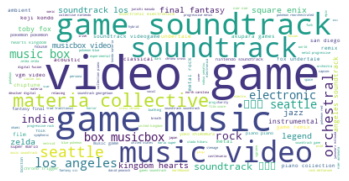

In [ ]:
# preprocessing tag data for wordcloud parameter input
text = ' '.join(all_tags).lower()
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, collocations=True).generate(text)

# plotting wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

# find error in soundtrack

This wordcloud doesn't give us much information. We know this dataset is based on videogame music, so keywords such as "video game" and "game music" become a bit redundant, and give little insight onto specific genres or popular games. To tweak this analysis, we added thesee keywords to our STOPWORDS list, which are common words that should not be included in the wordcloud.

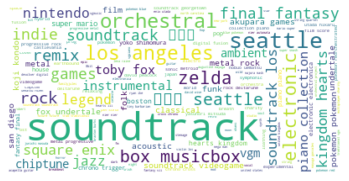

In [ ]:
# updating stopwords list
stop_words = ['game', 'music', 'video', 'materia', 'collective'] + sorted(STOPWORDS)
wordcloud2 = WordCloud(background_color='white', stopwords = stop_words, collocations=True).generate(text)

plt.imshow(wordcloud2, interpolation='bilInear')
plt.axis('off')
plt.show()

This wordcloud gives us a bit more information. From here, we can infer entire videogame soundtracks are commonly hosted on sites, as opposed to indivually released songs. We can also begin to see some popular gaming companies start to emege in the tags, such as "nintendo," "square enix," or even independent developers such a "toby fox." Interestingly, we also see a common occurance of "▯▯▯" which may indicate tags written in other languages that cannot be dected in the wordcloud. This gives insight on the diversity of nations popular videogame music is produced from, and whether or not their language is recognized by unicode characters.

Next, we wanted to explore how certain features of a song or ablum factor into their popularity. We narrowed this down to factors such as artist, price, tags, and track duration. First we will determine the Top 10 most popular artists. To obtain the arti

album_df --> bandcamp
track_df --> 

In [ ]:
# graphing popularity

# this is a zero inflated distribution

In [ ]:
# find most popular artists

spotify_df = pd.read_csv ('spotify_tracks_df.csv')
artists = spotify_df['Track Artists']
popularity = spotify_df['Popularity']

artists_array = []
popularities = []
all_artists = []
for artist in artists:
  artists_array.append(ast.literal_eval(artist))

for array in artists_array:
  for art in array:
    all_artists.append(art)

uniq_artists = list(set(all_artists))

artist_popularity = {}

for uniq_artist in uniq_artists:
  artist_popularity[uniq_artist] = []

for artist, pop in zip(artists, popularity):
  for uniq_artist in uniq_artists:
    if uniq_artist in artist:
      artist_popularity[uniq_artist].append(pop)
      
for artist in artist_popularity:
  value = artist_popularity[artist]
  artist_popularity[artist] = sum(value)/len(value)
  popularities.append(artist_popularity[artist])

artist_popularity
#album  --> spotify albums (tags, cost)
#spotfity tracks (artist, popularity, duration)

{'REVEN': 17.64814814814815,
 'Zohar Emulator': 0.0,
 'Michelle Heafy': 19.0,
 'Antonín Dvořák': 1.0,
 'Pei-Yu Hung': 22.0,
 'Video Game Orchestra': 8.418604651162791,
 'Doug Perry': 1.3333333333333333,
 'Valter Abreu': 0.0,
 'Joanne Moo': 0.3333333333333333,
 'Jackson Alexander Parodi': 1.0,
 'Louise Dodds': 5.0,
 'FamilyJules': 13.9375,
 'Louie Aronowitz': 0.0,
 'Hitoshi Sakimoto': 1.5714285714285714,
 'AdhesiveWombat': 6.0,
 'Sam Dillard': 15.0,
 'Jools Scott': 0.0,
 'Chris Rigby': 3.0,
 'Steven Higbee': 17.0,
 'ETHEReal String Orchestra': 3.9722222222222223,
 'Brendon Williams': 10.0,
 'Grant Kirkhope': 5.774193548387097,
 'Marissa Hapeman': 0.0,
 'Alexandre Choinière': 2.0,
 'Baircave': 3.0,
 'Thennecan': 6.0,
 'Jacob Pernell': 0.0,
 'Michael Staple': 0.14285714285714285,
 'Hyper Potions': 13.0,
 'Gemanon': 7.0,
 'Hitomi Sato': 24.833333333333332,
 'Earth Kid': 7.0,
 'Songe': 8.0,
 'Mega Ran': 7.0,
 'The Arkadian': 1.5,
 'Sirenstar': 6.0,
 'Damokles': 0.0,
 'Delicious Nick': 1.0,


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12379 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12376 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12379 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12356 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12376 missing from current font.
  font.set_text

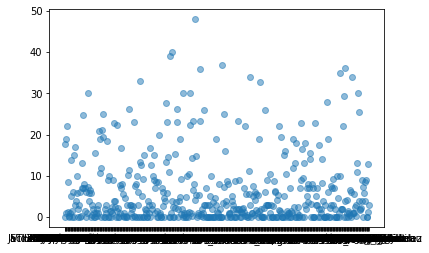

In [ ]:
import matplotlib.pyplot as plt

#plt.scatter(uniq_artists, popularities, alpha=0.5)
#plt.show()

In [ ]:
# find most popular artists over time

Next, we will determine popularity of an album versus price of the album. This was motivated by wanting to see if a high price point would deter purchases, or if fans of a niche music subgroup may be willing to spend a premuim on songs from games or fanbases they are more dedicated to.

In [ ]:
# determine average price

full_df = pd.read_csv ('full_album_df.csv')
prices = full_df['CD Price']
prices = [x for x in prices if str(x) != 'nan']
avg_price = sum(prices)/len(prices)
avg_price
# around $22.07 per album

,Track ID,Track Title,Track Artists,Popularity,Duration (ms),Track Number,Album Title,Album ID
0,7xK2Yu4Stpp9Nali4FiVZ4,Tavern in the Mist,['Mike Skalandunas'],3,156981,14,0 A.D. (Original Game Soundtrack),418tEkWnpAD7HHYWZfNgj4
1,7tslLLf1JFqCps4c6Kw40B,Valley of the Nile,"['Omri Lahav', 'Sholmi Nogay']",10,161500,20,0 A.D. (Original Game Soundtrack),418tEkWnpAD7HHYWZfNgj4
2,0Nyk2AANZ1NhKU1ZH0O9dm,In the Shadow of Olympus,['Omri Lahav'],3,242500,19,0 A.D. (Original Game Soundtrack),418tEkWnpAD7HHYWZfNgj4
3,2rCIHhlo1lJ9WrVeDcNsVH,An Old Warhorse Goes to Pasture,['Omri Lahav'],2,200500,18,0 A.D. (Original Game Soundtrack),418tEkWnpAD7HHYWZfNgj4
4,2y4tZ715e6fSN5Pwci4LTF,Elusive Predator,['Jeff Willet'],2,177103,17,0 A.D. (Original Game Soundtrack),418tEkWnpAD7HHYWZfNgj4
...,...,...,...,...,...,...,...,...
5049,43SRc8OHZCcabJC6RYS6wC,Battle of Gods,['Chris Porter'],0,222345,6,ikenie (Original Game Soundtrack),4YRa0ha9mJNhNOrRRKvwWe
5050,60KW6BgPcNAWxUOZsMDqG3,Universe,['Chris Porter'],0,82127,5,ikenie (Original Game Soundtrack),4YRa0ha9mJNhNOrRRKvwWe
5051,6M1wuSTYUBBRZVDts44WeI,The Path of the Sun God,['Chris Porter'],0,270532,4,ikenie (Original Game Soundtrack),4YRa0ha9mJNhNOrRRKvwWe
5052,3SprNFpqdEHl2WTypk2KCN,Predators of the Night,['Chris Porter'],0,84152,3,ikenie (Original Game Soundtrack),4YRa0ha9mJNhNOrRRKvwWe


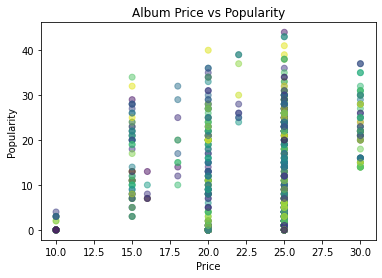

In [ ]:
# graph price over popularity
import numpy as np
merge_df = pd.merge(spotify_df, full_df, on='Album ID', how='left')

prices = merge_df['CD Price']
popularity = merge_df['Popularity']
colors = np.random.rand(5134)

plt.scatter(prices, popularity, c=colors, alpha=0.5)
plt.title("Album Price vs Popularity")
plt.xlabel("Price")
plt.ylabel("Popularity")
plt.show()

In [ ]:
# find number of tags per album
album = df['Album Title']

album_and_tags = {}

for al, t in zip(album, tag):
  album_and_tags[al] = t

album_and_tags

{'Moss (Original Game Soundtrack)': 'S',
 'Moss: Book II (Original Game Soundtrack)': 'w',
 'Nightslink (Original Game Soundtrack)': 'e',
 'Shadows Over Loathing (Original Game Soundtrack)': 'd',
 'Pursuit ~ A Great Turnabout (from "The Great Ace Attorney")': 'e',
 'Music Box Classics: KINGDOM HEARTS II': 'n'}

In [ ]:
duration = spotify_df['Duration (ms)']
durations = []

for song in duration:
  durations.append(song)

# finding mean duration
mean_duration = sum(duration)/len(duration)

# converting milliseconds to seconds
seconds_raw = mean_duration/1000

# the average track is 177.50736005911693 seconds long
minutes_raw = seconds_raw/60

# the average track is 2.958456000985282 minutes long
# time is measured in base 60, so we multiply the remainder by 60

remaining = 0.958456000985282 * 60

#This comes to about 2 minutes and 58 seconds per track

57.50736005911692

In [ ]:
# are longer songs more popular? does length of song contrubte to popularity
# graphs of length v popularity



In [ ]:
# popularity of the song versus track order
# find most popular song in album and note the track number

# do videogame soundtracks typically lead with their leading single from the game, or are the tracks listed 
# through a more wholistic, or perhaps chronological approach


# Hypothesis Testing

In [ ]:
#given an album how how much ill it cost

# does more songs or alonger duration mean higher cost

# does more popular artists cintrbyte to cost

# outside facvtors that will not be considred id the popularity of the game itsel -- we recognize this is a important
# contributing factor but this analysis falls outside the the realm of this data

# Conclusion & Additional Insights